In [ ]:
!pip install catboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from dateutil import parser
from collections import defaultdict
from copy import deepcopy
import random
import statistics
import math
import numpy as np
import ast
import statistics
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from catboost import CatBoostClassifier

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/LDF

/content/drive/.shortcut-targets-by-id/10cLNvGYZ8jCz5UzVVMmUw1kONRPJ_red/LDF


# Help functions

## Data imputation

In [ ]:
def data_imputation(X_train, X_test, imputation_method='mean'):
  # This function imputes the data based on the train set
  # and apply the imputed values to the test set

  if imputation_method == 'mean':

    # Calculate mean per column
    n = len(X_train[0])
    memo = [np.asfarray([0 for i in range(n)]), np.asfarray([0.0 for i in range(n)])] # [Count, Sum]

    for i in range(len(X_train)):
      for j in range(len(X_train[i])):
        if np.isnan(X_train[i][j]) != True:
          memo[0][j] += 1
          memo[1][j] += X_train[i][j]

    for j in range(n):
      memo[1][j] = memo[1][j]/memo[0][j] # ==> [Count, Mean]

    # Data imputation
    for i in range(len(X_train)):
      for j in range(len(X_train[i])):
        if np.isnan(X_train[i][j]) == True:
          X_train[i][j] = memo[1][j]

    for i in range(len(X_test)):
      for j in range(len(X_test[i])):
        if np.isnan(X_test[i][j]) == True:
          X_test[i][j] = memo[1][j]

  return X_train, X_test

## In-the-loop normalization

In [ ]:
def data_normalization(X_train, X_test):
  # This function normalizes the data based on the train set
  # and apply the normalized values to the test set

  # Convert to float to get more precise results (yet empirically proved)
  X_train = np.asfarray(X_train)
  X_test = np.asfarray(X_test)

  # Memoization: [Minimums, Maximums]
  memo = deepcopy([X_train[0], X_train[0]])
  for row in X_train:
    for i in range(len(row)):
      if row[i] < memo[0][i]:
        memo[0][i] = row[i]
      if row[i] > memo[1][i]:
        memo[1][i] = row[i]

  # Normalization on train set
  for r in range(len(X_train)):
    for c in range(len(X_train[0])):
      if memo[1][c]-memo[0][c] == 0:
        X_train[r][c] = (X_train[r][c] - memo[0][c])/(1e-20)
      else:
        X_train[r][c] = (X_train[r][c] - memo[0][c])/(memo[1][c]-memo[0][c])

  # Normalization on test set
  for r in range(len(X_test)):
    for c in range(len(X_test[0])):
      if memo[1][c]-memo[0][c] == 0:
        X_test[r][c] = (X_test[r][c] - memo[0][c])/(1e-20)
      else:
        X_test[r][c] = (X_test[r][c] - memo[0][c])/(memo[1][c]-memo[0][c])
      # Rescale
      if X_test[r][c] > 1.0:
        X_test[r][c] = 1.0
      elif X_test[r][c] < 0.0:
        X_test[r][c] = 0.0

  return X_train, X_test

## Leave one person out

In [ ]:
def leave_one_person_out(patient_ids):
  loo = dict()
  for patient_id in set(patient_ids):
    loo[patient_id] = None

  for patient_id in loo:
    train_indices, test_indices = [], []

    for i in range(len(patient_ids)):
      if patient_ids[i] == patient_id:
        test_indices.append(i)
      else:
        train_indices.append(i)

    loo[patient_id] = [train_indices, test_indices]

  return loo

## K-fold

In [ ]:
def k_fold(patient_ids, number_of_folds = 5):
  patient_id_dict = dict()
  for patient_id in set(patient_ids):
    patient_id_dict[patient_id] = []

  for i in range(len(patient_ids)):
    patient_id = patient_ids[i]
    patient_id_dict[patient_id].append(i)

  kfold_dict = dict()
  i, k = 0, len(patient_id_dict.keys())//number_of_folds
  queue = list(patient_id_dict.keys())

  while queue:
    random.shuffle(queue)
    patient_id_test = [j for j in queue[0:k] ]
    patient_id_train = [j for j in set(patient_id_dict.keys())-set(patient_id_test) ]

    train_indices, test_indices = [], []
    for patient_id in patient_id_train:
      train_indices += patient_id_dict[patient_id]
    for patient_id in patient_id_test:
      test_indices += patient_id_dict[patient_id]
    kfold_dict[i] = [train_indices, test_indices]

    queue = queue[k:]
    i += 1

  return kfold_dict

## AUC plot

In [ ]:
def AUC_plot(y, preds):
  figure, axis = plt.subplots(1, 2)

  # ROC AUC
  fpr, tpr, thresholds = roc_curve(y, preds, #pos_label=1
                                   )
  roc_auc = round(auc(fpr, tpr), 4)
  print('ROC AUC: ', roc_auc)
  #print('FPR: ', fpr, 'TPR: ', tpr) # For debugging
  axis[0].plot(fpr, tpr)
  axis[0].set_title('ROC AUC')
  axis[0].set_xlabel('FPR')
  axis[0].set_ylabel('TPR')

  # PR AUC
  precision, recall, thresholds = precision_recall_curve(y, preds, pos_label=1)
  pr_auc = round(auc(recall,precision), 4)
  print('PR AUC: ', pr_auc)
  #print('Recall: ', recall, 'Precision: ', precision) # For debugging
  axis[1].plot(recall, precision)
  axis[1].set_title('ROC PR')
  axis[1].set_xlabel('Recall')
  axis[1].yaxis.set_label_position("right")
  axis[1].set_ylabel('Precision')

  plt.show()

## One-hot encoding

In [ ]:
def onehot_encoding(df):
  # Encode categorical variables and store the mapping
  label_encoder = LabelEncoder()
  encoded_values = {}

  for column in df.columns:
    if df[column].dtype == 'O' and column != '1. Volunteer full name':
      df[column] = label_encoder.fit_transform(df[column])
      encoded_values[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

      print(f'Feature: {column} \n', encoded_values[f'{column}'])

  return encoded_values, df

## MLP Binary

In [ ]:
# Define the MLP architecture for binary classification
class MLPBinary(nn.Module):
  def __init__(self, input_size, hidden_size, dropout_prob):
    super(MLPBinary, self).__init__()
    self.layer_norm = nn.LayerNorm(input_size)
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout_prob)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = self.layer_norm(x)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc3(out)
    out = self.sigmoid(out)
    return out


def MLP_training(X_train, X_test, y_train, y_test):
  # Data imputation
  X_train, X_test = data_imputation(X_train, X_test,
                                    imputation_method='mean')

  # Data normalization
  X_train, X_test = data_normalization(X_train, X_test)

  # Convert NumPy arrays to PyTorch tensors
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

  # Convert data to PyTorch tensors
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

  # Create DataLoader
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Initialize model, loss function, and optimizer
  model = MLPBinary(input_size, hidden_size, dropout_prob)
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Define variables to track the best model and its accuracy
  best_accuracy = 0
  best_model = None

  # Training the model
  for epoch in range(num_epochs):
    # Train
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels.unsqueeze(1))
      loss.backward()
      optimizer.step()

      # Evaluate on train set
      train_outputs = model(X_train_tensor)
      train_predicted = (train_outputs > 0.5).squeeze().int()
      train_accuracy = (train_predicted == y_train_tensor.int()).sum().item() / len(y_train_tensor)

    # Evaluate on test set
    with torch.no_grad():
      model.eval()
      test_outputs = model(X_test_tensor)
      test_predicted = (test_outputs > 0.5).squeeze().int()
      test_accuracy = (test_predicted == y_test_tensor.int()).sum().item() / len(y_test_tensor)

    # Print accuracy for each epoch
    print('Epoch [{}/{}], Train Accuracy: {:.4f}, Test Accuracy: {:.4f}'.format(epoch+1, num_epochs, train_accuracy, test_accuracy))

    # Save the best model
    if test_accuracy > best_accuracy:
      best_accuracy = test_accuracy
      best_model = model.state_dict()

  # Save the best model
  torch.save(best_model, 'best_model.pth')


def MLP_inference(X_test):
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  model = MLPBinary(input_size, hidden_size, dropout_prob)
  model.load_state_dict(torch.load('best_model.pth'))
  model.eval()

  with torch.no_grad():
    y_test_predicted = model(X_test_tensor).squeeze()
    y_test_predicted = y_test_predicted.numpy()

  return y_test_predicted

# Sensor features - Binary classification

In [ ]:
df_rawdata = pd.read_excel('Data/20-05-2024_TextNorm.xlsx')
print(df_rawdata.dtypes)
df_rawdata

Type of data                                 object
Patient_ID                                   object
Kv100                                       float64
M                                           float64
δ                                           float64
T                                           float64
A365                                        float64
A460                                        float64
Anadn                                       float64
POM                                         float64
Ae                                          float64
An                                          float64
Am                                          float64
Ar                                          float64
Ac                                          float64
F_Ae                                        float64
F_An                                        float64
F_Am                                        float64
F_Ar                                        float64
F_Ac        

,Type of data,Patient_ID,Kv100,M,δ,T,A365,A460,Anadn,POM,...,Disease,Blood Pressure,Level of BP,Heart Rate,DASS_21,Stress,Anxiety,Depression,Hypertension,Non-wellbeing
0,Original,Minh Ngoc Nguyen,12.90,22.50,2.90,32.01,114.0,62.0,0.54,5.68,...,Migraine,Normal,0,95.0,NORMAL,0,0,0,0,0
1,Original,Minh Ngoc Nguyen,22.28,22.55,5.02,32.14,122.0,42.0,0.34,10.38,...,Migraine,Normal,0,95.0,NORMAL,0,0,0,0,0
2,Filter,Minh Ngoc Nguyen,11.10,22.85,2.54,32.04,114.0,62.0,0.54,7.54,...,Migraine,Normal,0,95.0,NORMAL,0,0,0,0,0
3,Filter,Minh Ngoc Nguyen,20.78,23.01,4.78,23.01,122.0,41.0,0.33,11.31,...,Migraine,Normal,0,95.0,NORMAL,0,0,0,0,0
4,Original,Hong Pham,20.76,4.39,0.91,24.44,132.0,93.0,0.70,0.91,...,Migraine,Normal,0,70.0,NORMAL,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,Original,Giang Thi Sot,28.89,16.62,4.80,30.75,78.0,97.0,1.24,3.02,...,"Diabetes, MACE",Elevated,1,70.0,NORMAL,0,0,0,1,0
1074,Original,Nguyen Ba Tuyen,27.52,18.78,5.17,36.86,92.0,71.0,0.77,3.77,...,"Diabetes, MACE",Elevated,1,70.0,NORMAL,0,0,0,1,0
1075,Original,Nguyen Ba Tuyen,10.34,23.96,2.48,35.89,82.0,31.0,0.37,13.40,...,"Diabetes, MACE",Elevated,1,70.0,NORMAL,0,0,0,1,0
1076,Original,Mac Van Thang,26.75,24.51,6.56,35.07,53.0,40.0,0.77,7.49,...,MACE,Elevated,1,70.0,NORMAL,0,0,0,1,0


In [ ]:
# Convert Multiclass to Binary
for i in range(len(df_rawdata['DASS_21'])):
  if df_rawdata['DASS_21'][i] == 'NORMAL':
    pass
  else:
    df_rawdata['DASS_21'][i] = 'ABNORMAL'

# df_rawdata['DASS_21'].unique() # For debugging

# One-hot encoding
encoded_values, df_rawdata = onehot_encoding(df_rawdata)

In [ ]:
input = ['Kv100', 'M', 'δ', 'T', 'A365', 'A460', 'Anadn', 'POM', 'Ae', 'An', 'Am', 'Ar', 'Ac',
         'F_Ae', 'F_An', 'F_Am', 'F_Ar', 'F_Ac', 'Weight', 'Height', 'BMI_index',
         'Level of BP', 'Heart Rate']
output = [#'Ethnicity', 'Left or Right', 'Sleep', 'Gender', 'Race',
          #'Smoking',
          #'Disease',
          'DASS_21',
          #'Stress', 'Anxiety', 'Depression', 'Hypertension', 'Non-wellbeing'
          ]

X_rawdata = df_rawdata[input].values
y_dass21 = df_rawdata['DASS_21'].values

patient_ids = list(df_rawdata['Patient_ID'])

## Leave-one-patient-out

### Gradient Boosting

Gradient Boosting
ROC AUC:  0.6265
PR AUC:  0.8379


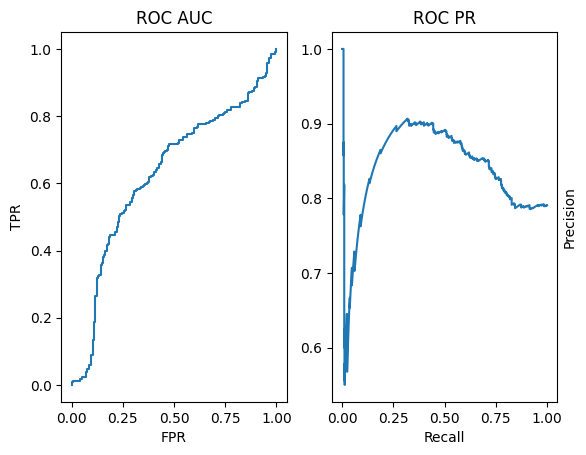

In [ ]:
# Gradient Boosting
d_preds = {'labels': [], 'preds': []}

loo = leave_one_person_out(patient_ids)

for patient_id in loo:
  # Leave one out
  train_indices = np.array(loo[patient_id][0])
  test_indices = np.array(loo[patient_id][1])

  X_rawdata_train = X_rawdata[train_indices]
  X_rawdata_test = X_rawdata[test_indices]
  y_dass21_train = y_dass21[train_indices]
  y_dass21_test = y_dass21[test_indices]

  # Data imputation
  X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                    imputation_method='mean')

  # Classification
  clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                   max_depth=1, random_state=0).fit(X_rawdata_train, y_dass21_train)
  d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
  d_preds['preds'] += [ np.array(val) for val in clf.predict_proba(X_rawdata_test)[:, 1] ]

print('Gradient Boosting')
AUC_plot(d_preds['labels'], d_preds['preds'])

### Catboost

Catboost
ROC AUC:  0.4753
PR AUC:  0.7556


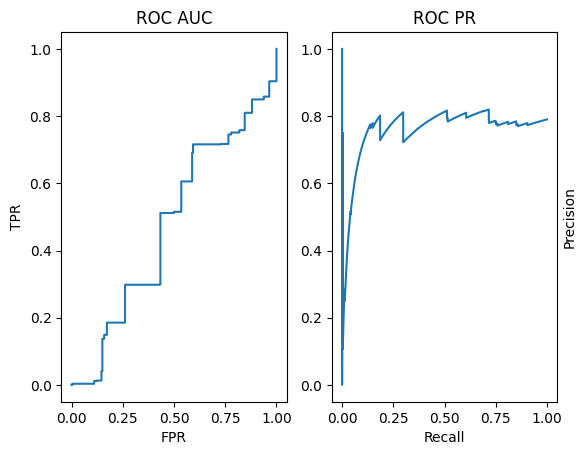

In [26]:
# Catboost
d_preds = {'labels': [], 'preds': []}

loo = leave_one_person_out(patient_ids)

for patient_id in loo:
  # Leave one out
  train_indices = np.array(loo[patient_id][0])
  test_indices = np.array(loo[patient_id][1])

  X_rawdata_train = X_rawdata[train_indices]
  X_rawdata_test = X_rawdata[test_indices]
  y_dass21_train = y_dass21[train_indices]
  y_dass21_test = y_dass21[test_indices]

  # Data imputation
  X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                    imputation_method='mean')

  # Classification
  clf = CatBoostClassifier(iterations=2, learning_rate=1, depth=2)
  clf.fit(X_rawdata_train, y_dass21_train, verbose=False)
  d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
  d_preds['preds'] += [ np.array(val) for val in clf.predict_proba(X_rawdata_test)[:, 1] ]

print('Catboost')
AUC_plot(d_preds['labels'], d_preds['preds'])

### LightGBM

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM
ROC AUC:  0.698
PR AUC:  0.9091


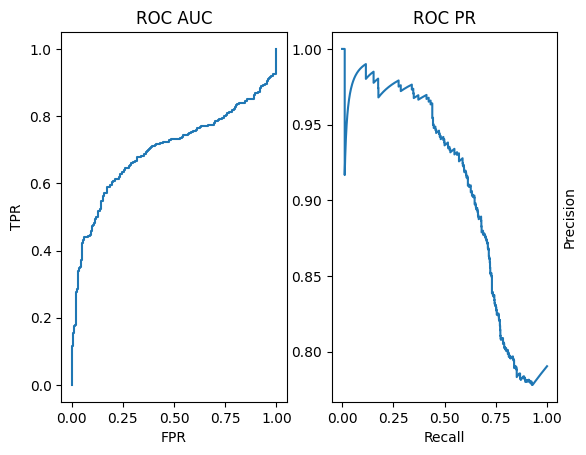

In [ ]:
# LightGBM
d_preds = {'labels': [], 'preds': []}

loo = leave_one_person_out(patient_ids)

for patient_id in loo:
  # Leave one out
  train_indices = np.array(loo[patient_id][0])
  test_indices = np.array(loo[patient_id][1])

  X_rawdata_train = X_rawdata[train_indices]
  X_rawdata_test = X_rawdata[test_indices]
  y_dass21_train = y_dass21[train_indices]
  y_dass21_test = y_dass21[test_indices]

  # Data imputation
  X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                    imputation_method='mean')

  # Classification
  train_data = lgb.Dataset(X_rawdata_train, label=y_dass21_train)
  test_data = lgb.Dataset(X_rawdata_test, label=y_dass21_test, reference=train_data)
  params = {
      'objective': 'binary',
      'metric': 'binary_logloss',
      'num_leaves': 31,
      #'learning_rate': 0.05,
      'learning_rate': 0.1,
      'n_estimators': 100,
      'verbose': -1
  }
  bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
  y_dass21_test_preds = bst.predict(X_rawdata_test, num_iteration=bst.best_iteration)

  d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
  d_preds['preds'] += [ np.array(val) for val in y_dass21_test_preds ]

print('LightGBM')
AUC_plot(d_preds['labels'], d_preds['preds'])

### SVM

SVM
ROC AUC:  0.5124
PR AUC:  0.8113


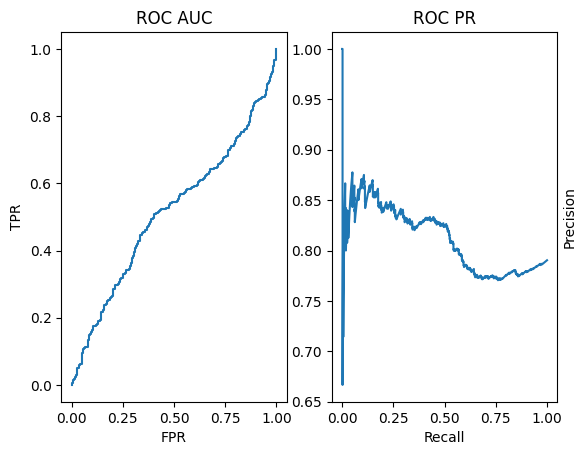

In [ ]:
# SVM
d_preds = {'labels': [], 'preds': []}

loo = leave_one_person_out(patient_ids)

for patient_id in loo:
  # Leave one out
  train_indices = np.array(loo[patient_id][0])
  test_indices = np.array(loo[patient_id][1])

  X_rawdata_train = X_rawdata[train_indices]
  X_rawdata_test = X_rawdata[test_indices]
  y_dass21_train = y_dass21[train_indices]
  y_dass21_test = y_dass21[test_indices]

  # Data imputation
  X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                    imputation_method='mean')

  # Classification
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
  clf.fit(X_rawdata_train, y_dass21_train)
  d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
  d_preds['preds'] += [ np.array(val) for val in clf.predict_proba(X_rawdata_test)[:, 1] ]

print('SVM')
AUC_plot(d_preds['labels'], d_preds['preds'])

### Random forest

Random forest
ROC AUC:  0.556
PR AUC:  0.8209


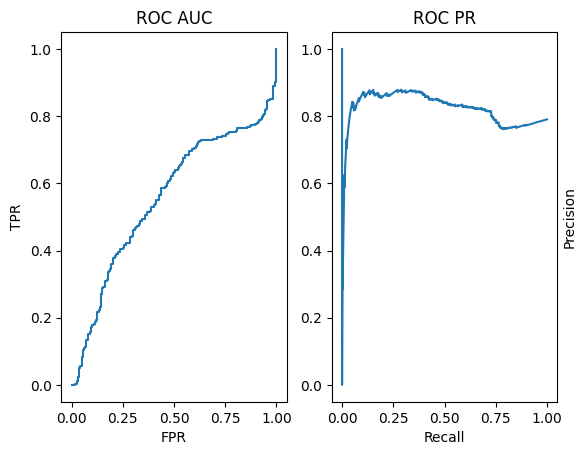

In [ ]:
# Random forest
d_preds = {'labels': [], 'preds': []}

loo = leave_one_person_out(patient_ids)

for patient_id in loo:
  # Leave one out
  train_indices = np.array(loo[patient_id][0])
  test_indices = np.array(loo[patient_id][1])

  X_rawdata_train = X_rawdata[train_indices]
  X_rawdata_test = X_rawdata[test_indices]
  y_dass21_train = y_dass21[train_indices]
  y_dass21_test = y_dass21[test_indices]

  # Data imputation
  X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                    imputation_method='mean')

  # Classification
  clf = RandomForestClassifier(max_depth=2, random_state=0)
  clf.fit(X_rawdata_train, y_dass21_train)
  d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
  d_preds['preds'] += [ np.array(val) for val in clf.predict_proba(X_rawdata_test)[:, 1] ]

print('Random forest')
AUC_plot(d_preds['labels'], d_preds['preds'])

### MLP

Epoch [1/20], Train Accuracy: 0.7963, Test Accuracy: 0.1111
Epoch [2/20], Train Accuracy: 0.7963, Test Accuracy: 0.1111
Epoch [3/20], Train Accuracy: 0.7963, Test Accuracy: 0.1111
Epoch [4/20], Train Accuracy: 0.7963, Test Accuracy: 0.1111
Epoch [5/20], Train Accuracy: 0.7963, Test Accuracy: 0.1111
Epoch [6/20], Train Accuracy: 0.8000, Test Accuracy: 0.1111
Epoch [7/20], Train Accuracy: 0.8047, Test Accuracy: 0.1111
Epoch [8/20], Train Accuracy: 0.8000, Test Accuracy: 0.1111
Epoch [9/20], Train Accuracy: 0.8093, Test Accuracy: 0.1111
Epoch [10/20], Train Accuracy: 0.8159, Test Accuracy: 0.1111
Epoch [11/20], Train Accuracy: 0.8178, Test Accuracy: 0.1111
Epoch [12/20], Train Accuracy: 0.8514, Test Accuracy: 0.1111
Epoch [13/20], Train Accuracy: 0.8645, Test Accuracy: 0.1111
Epoch [14/20], Train Accuracy: 0.8738, Test Accuracy: 0.1111
Epoch [15/20], Train Accuracy: 0.8710, Test Accuracy: 0.1111
Epoch [16/20], Train Accuracy: 0.8841, Test Accuracy: 0.1111
Epoch [17/20], Train Accuracy: 0.

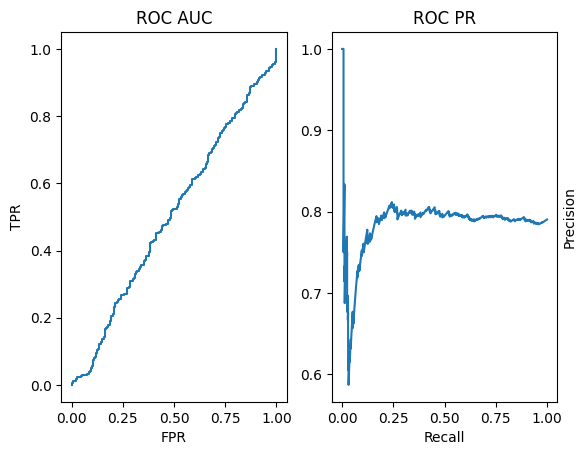

In [ ]:
# MLP

# Define hyperparameters
input_size = X_rawdata.shape[1]
hidden_size = 64
num_epochs = 20
batch_size = 32
dropout_prob = 0.05
learning_rate = 0.001

d_preds = {'labels': [], 'preds': []}

loo = leave_one_person_out(patient_ids)

for patient_id in loo:
  # Leave one out
  train_indices = np.array(loo[patient_id][0])
  test_indices = np.array(loo[patient_id][1])

  X_rawdata_train = X_rawdata[train_indices]
  X_rawdata_test = X_rawdata[test_indices]
  y_dass21_train = y_dass21[train_indices]
  y_dass21_test = y_dass21[test_indices]

  # Data imputation
  X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                    imputation_method='mean')

  # Dummy
  flag = None
  if len(set(y_dass21_test)) == 1:
    for i in range(len(y_dass21)):
      if y_dass21[i] == 1 - y_dass21_test[0]:
        X_rawdata_test = np.concatenate((np.reshape(X_rawdata[i], (1,-1)), X_rawdata_test), axis=0)
        y_dass21_test = np.concatenate((np.array([y_dass21[i]]), y_dass21_test), axis=0)
        flag = True
        break

  # Classification
  MLP_training(X_rawdata_train, X_rawdata_test, y_dass21_train, y_dass21_test)
  y_test_predicted = MLP_inference(X_rawdata_test)

  if flag == True:
    y_dass21_test, y_test_predicted = y_dass21_test[1:], y_test_predicted[1:]

  d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
  d_preds['preds'] += [ np.array(val) for val in y_test_predicted ]

print('MLP')
AUC_plot(d_preds['labels'], d_preds['preds'])

## K-fold

### Gradient Boosting

Gradient Boosting
ROC AUC:  0.6137
PR AUC:  0.8424


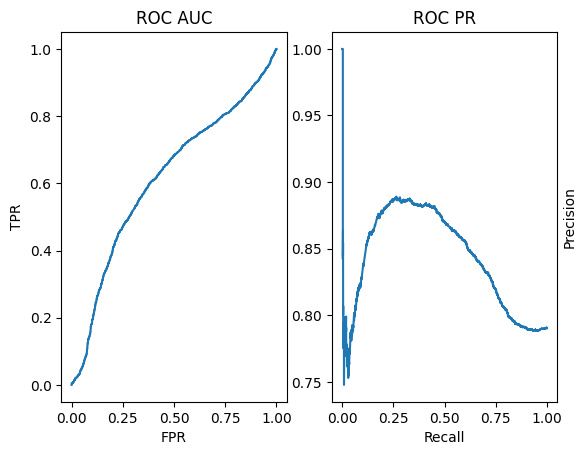

In [ ]:
# Gradient Boosting
d_preds = {'labels': [], 'preds': []}

for seed in range(10):
  kfold = k_fold(patient_ids, number_of_folds=5)
  for k in kfold:
    # K-fold
    train_indices = np.array(kfold[k][0])
    test_indices = np.array(kfold[k][1])

    X_rawdata_train = X_rawdata[train_indices]
    X_rawdata_test = X_rawdata[test_indices]
    y_dass21_train = y_dass21[train_indices]
    y_dass21_test = y_dass21[test_indices]

    # Data imputation
    X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                      imputation_method='mean')

    # Classification
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                    max_depth=1, random_state=0).fit(X_rawdata_train, y_dass21_train)
    d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
    d_preds['preds'] += [ np.array(val) for val in clf.predict_proba(X_rawdata_test)[:, 1] ]

print('Gradient Boosting')
AUC_plot(d_preds['labels'], d_preds['preds'])

### Catboost

Catboost
ROC AUC:  0.5145
PR AUC:  0.7914


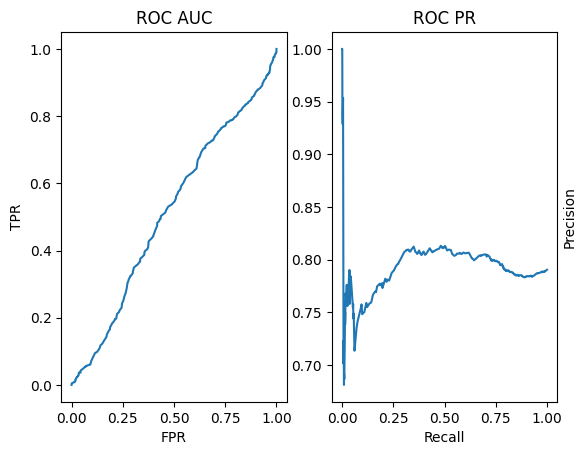

In [ ]:
# Catboost
d_preds = {'labels': [], 'preds': []}

for seed in range(10):
  kfold = k_fold(patient_ids, number_of_folds=5)
  for k in kfold:
    # K-fold
    train_indices = np.array(kfold[k][0])
    test_indices = np.array(kfold[k][1])

    X_rawdata_train = X_rawdata[train_indices]
    X_rawdata_test = X_rawdata[test_indices]
    y_dass21_train = y_dass21[train_indices]
    y_dass21_test = y_dass21[test_indices]

    # Data imputation
    X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                      imputation_method='mean')

    # Classification
    clf = CatBoostClassifier(iterations=2, learning_rate=1, depth=2)
    clf.fit(X_rawdata_train, y_dass21_train, verbose=False)
    d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
    d_preds['preds'] += [ np.array(val) for val in clf.predict_proba(X_rawdata_test)[:, 1] ]

print('Catboost')
AUC_plot(d_preds['labels'], d_preds['preds'])

### LightGBM

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LightGBM
ROC AUC:  0.6601
PR AUC:  0.8839


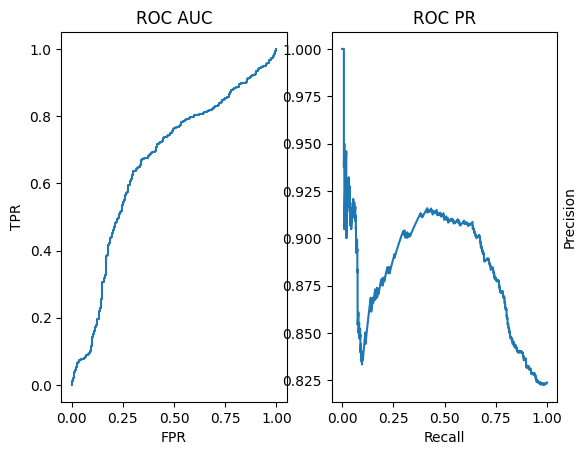

In [ ]:
# LightGBM
d_preds = {'labels': [], 'preds': []}

for seed in range(10):
  kfold = k_fold(patient_ids, number_of_folds=5)
  for k in kfold:
    # K-fold
    train_indices = np.array(kfold[k][0])
    test_indices = np.array(kfold[k][1])

    X_rawdata_train = X_rawdata[train_indices]
    X_rawdata_test = X_rawdata[test_indices]
    y_dass21_train = y_dass21[train_indices]
    y_dass21_test = y_dass21[test_indices]

    # Data imputation
    X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                      imputation_method='mean')

    # Classification
  train_data = lgb.Dataset(X_rawdata_train, label=y_dass21_train)
  test_data = lgb.Dataset(X_rawdata_test, label=y_dass21_test, reference=train_data)
  params = {
      'objective': 'binary',
      'metric': 'binary_logloss',
      'num_leaves': 31,
      #'learning_rate': 0.05,
      'learning_rate': 0.1,
      'n_estimators': 100,
      'verbose': -1
  }
  bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
  y_dass21_test_preds = bst.predict(X_rawdata_test, num_iteration=bst.best_iteration)

  d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
  d_preds['preds'] += [ np.array(val) for val in y_dass21_test_preds ]

print('LightGBM')
AUC_plot(d_preds['labels'], d_preds['preds'])

### SVM

SVM
ROC AUC:  0.5389
PR AUC:  0.8207


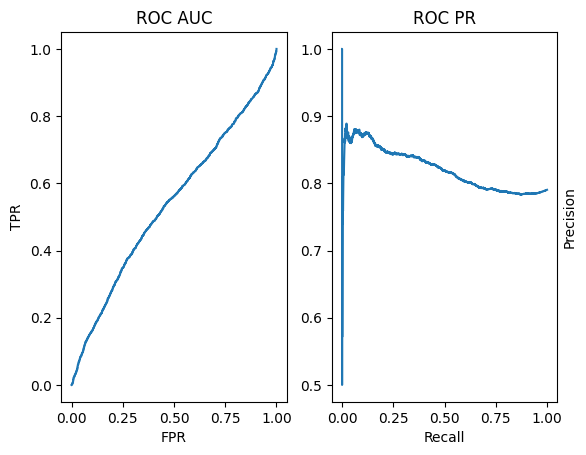

In [ ]:
# SVM
d_preds = {'labels': [], 'preds': []}

for seed in range(10):
  kfold = k_fold(patient_ids, number_of_folds=5)
  for k in kfold:
    # K-fold
    train_indices = np.array(kfold[k][0])
    test_indices = np.array(kfold[k][1])

    X_rawdata_train = X_rawdata[train_indices]
    X_rawdata_test = X_rawdata[test_indices]
    y_dass21_train = y_dass21[train_indices]
    y_dass21_test = y_dass21[test_indices]

    # Data imputation
    X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                      imputation_method='mean')

    # Classification
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
    clf.fit(X_rawdata_train, y_dass21_train)
    d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
    d_preds['preds'] += [ np.array(val) for val in clf.predict_proba(X_rawdata_test)[:, 1] ]

print('SVM')
AUC_plot(d_preds['labels'], d_preds['preds'])

### Random forest

Random forest
ROC AUC:  0.5607
PR AUC:  0.8261


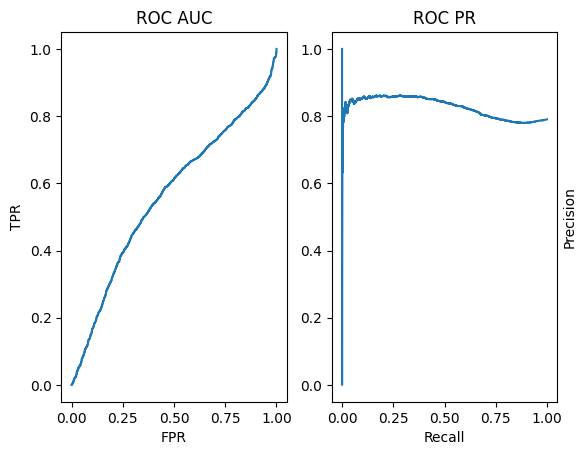

In [ ]:
# Random forest
d_preds = {'labels': [], 'preds': []}

for seed in range(10):
  kfold = k_fold(patient_ids, number_of_folds=5)
  for k in kfold:
    # K-fold
    train_indices = np.array(kfold[k][0])
    test_indices = np.array(kfold[k][1])

    X_rawdata_train = X_rawdata[train_indices]
    X_rawdata_test = X_rawdata[test_indices]
    y_dass21_train = y_dass21[train_indices]
    y_dass21_test = y_dass21[test_indices]

    # Data imputation
    X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                      imputation_method='mean')

    # Classification
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(X_rawdata_train, y_dass21_train)
    d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
    d_preds['preds'] += [ np.array(val) for val in clf.predict_proba(X_rawdata_test)[:, 1] ]

print('Random forest')
AUC_plot(d_preds['labels'], d_preds['preds'])

### MLP

Epoch [1/20], Train Accuracy: 0.8179, Test Accuracy: 0.6335
Epoch [2/20], Train Accuracy: 0.8179, Test Accuracy: 0.6335
Epoch [3/20], Train Accuracy: 0.8179, Test Accuracy: 0.6335
Epoch [4/20], Train Accuracy: 0.8179, Test Accuracy: 0.6335
Epoch [5/20], Train Accuracy: 0.8179, Test Accuracy: 0.6335
Epoch [6/20], Train Accuracy: 0.8222, Test Accuracy: 0.6335
Epoch [7/20], Train Accuracy: 0.8233, Test Accuracy: 0.6335
Epoch [8/20], Train Accuracy: 0.8244, Test Accuracy: 0.6335
Epoch [9/20], Train Accuracy: 0.8462, Test Accuracy: 0.6087
Epoch [10/20], Train Accuracy: 0.8746, Test Accuracy: 0.5963
Epoch [11/20], Train Accuracy: 0.8855, Test Accuracy: 0.5901
Epoch [12/20], Train Accuracy: 0.8866, Test Accuracy: 0.5839
Epoch [13/20], Train Accuracy: 0.9117, Test Accuracy: 0.5963
Epoch [14/20], Train Accuracy: 0.9106, Test Accuracy: 0.5901
Epoch [15/20], Train Accuracy: 0.8888, Test Accuracy: 0.5963
Epoch [16/20], Train Accuracy: 0.9019, Test Accuracy: 0.5963
Epoch [17/20], Train Accuracy: 0.

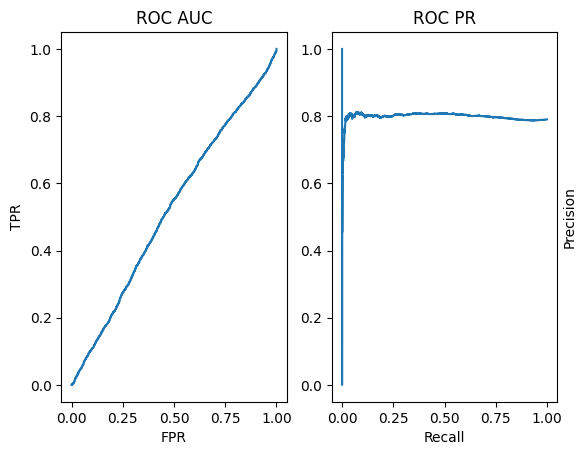

In [ ]:
# MLP

# Define hyperparameters
input_size = X_rawdata.shape[1]
hidden_size = 64
num_epochs = 20
batch_size = 32
dropout_prob = 0.05
learning_rate = 0.001

d_preds = {'labels': [], 'preds': []}

for seed in range(10):
  kfold = k_fold(patient_ids, number_of_folds=5)
  for k in kfold:
    # K-fold
    train_indices = np.array(kfold[k][0])
    test_indices = np.array(kfold[k][1])

    X_rawdata_train = X_rawdata[train_indices]
    X_rawdata_test = X_rawdata[test_indices]
    y_dass21_train = y_dass21[train_indices]
    y_dass21_test = y_dass21[test_indices]

    # Data imputation
    X_rawdata_train, X_rawdata_test = data_imputation(X_rawdata_train, X_rawdata_test,
                                                      imputation_method='mean')

    # Dummy
    flag = None
    if len(set(y_dass21_test)) == 1:
      for i in range(len(y_dass21)):
        if y_dass21[i] == 1 - y_dass21_test[0]:
          X_rawdata_test = np.concatenate((np.reshape(X_rawdata[i], (1,-1)), X_rawdata_test), axis=0)
          y_dass21_test = np.concatenate((np.array([y_dass21[i]]), y_dass21_test), axis=0)
          flag = True
          break

    # Classification
    MLP_training(X_rawdata_train, X_rawdata_test, y_dass21_train, y_dass21_test)
    y_test_predicted = MLP_inference(X_rawdata_test)

    if flag == True:
      y_dass21_test, y_test_predicted = y_dass21_test[1:], y_test_predicted[1:]

    d_preds['labels'] += [ np.array(val) for val in y_dass21_test ]
    d_preds['preds'] += [ np.array(val) for val in y_test_predicted ]

print('MLP')
AUC_plot(d_preds['labels'], d_preds['preds'])